<a href="https://colab.research.google.com/github/kmachina/cv_course/blob/master/leaf_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

os.environ['KAGGLE_USERNAME'] = 'kimbochen'
os.environ['KAGGLE_KEY'] = 'fcc31da31010e0b78a38e936d060dd8f'
CONTEST_NAME = 'leaf-classification'

!pip install --upgrade --force-reinstall --no-deps --quiet kaggle
!kaggle competitions download -q -c {CONTEST_NAME}
!unzip {CONTEST_NAME}.zip && rm -f {CONTEST_NAME}.zip
!unzip -q '*.zip' && rm -f *.zip

In [0]:
from __future__ import print_function, division

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

from pathlib import Path
from skimage import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
class LeafDataset(Dataset):
    def __init__(self, dataframe, tsfrm=None):
        self.df = dataframe
        self.img_dir = Path('/content/images')
        self.transforms = tsfrm

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.img_dir / f'{train_df.index[0]}.jpg'
        image = plt.imread(img_name)

        if self.transforms is not None:
            image = self.transforms(image)
        
        return image

In [0]:
def get_datasets():
    raw_df = pd.read_csv('/content/train.csv', index_col='id')
    raw_df = pd.get_dummies(raw_df, prefix='', prefix_sep='')

    train_df = raw_df.sample(frac=0.8,random_state=0)
    valid_df = raw_df.drop(train_df.index)
    test_df = pd.read_csv('/content/test.csv', index_col='id')

    train_ds = LeafDataset(train_df)
    valid_ds = LeafDataset(valid_df)
    test_ds = LeafDataset(test_df)

    return train_ds, valid_ds, test_ds

In [0]:
def show_image(img):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    ax.imshow(img, cmap='binary')
    plt.show()

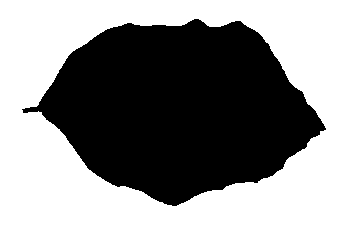

In [113]:
train_ds, valid_ds, test_ds = get_datasets()
show_image(test_ds[0])